In [0]:
def preprocess_train1(imgs, masks, gslice_ind):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    #Data Standardization is to subract mean and divide by std. This makes data with 0 mean and 1 std
    #(Whereas Noramlization is have data between 0 and 1. We are going with Standardization here)

    # mean = np.mean(imgs_p)  # mean
    # # print(mean)
    # std = np.std(imgs_p)  # std
    # # print(std)
    # imgs_p -= mean
    # imgs_p /= std
    #Normalize data between 0 and 1
    # imgs_p = (imgs_p - np.min(imgs_p)) / (np.max(imgs_p) - np.min(imgs_p))
    #Print Summary
    # print('Summary stats before and after preprocessing')
    # print('Min, Max, Mean, Median')
    # print(np.min(imgs), np.max(imgs), np.mean(imgs), np.median(imgs))
    # print(np.min(imgs_p), np.max(imgs_p), np.mean(imgs_p), np.median(imgs_p))
    np.save('pp_imgs_train1.npy', imgs_p)

    masks_p = np.ndarray((masks.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(masks.shape[0]):
        masks_p[i] = resize(masks[i], (img_cols, img_rows), preserve_range=True)
    masks_p = np.clip(masks_p, 0,2)
    masks_p = masks_p[..., np.newaxis]
    masks_p = masks_p.astype('uint8')
    np.save('pp_masks_train1.npy', masks_p)
    np.save('pp_gslice_ind1.npy', gslice_ind)
    return imgs_p, masks_p, gslice_ind

In [0]:
def get_train2_data(imgs_train, masks_train, imgs_train_predict ,imgs_train_bb, gslice_ind):
  masks_train_clipped = np.clip(masks_train, 0,1)
  blank_index = []
  min_val = np.min(imgs_train)
  img_rows = 256
  img_cols = 256
  imgs_train2 = np.ndarray((len(imgs_train_bb), img_rows, img_cols), dtype = np.float32)
  masks_train2 = np.ndarray((len(imgs_train_bb), img_rows, img_cols), dtype = np.uint8)
  for k,box in enumerate(imgs_train_bb):
  # print(k)
    img = imgs_train[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    # mask = imgs_train_predict[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    mask = masks_train_clipped[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    if(img.shape[0]*img.shape[1]==0):
      blank_index.append(k)
      continue
    img = np.multiply(img, mask)
    img = img.reshape((img.shape[0],img.shape[1]))

    result = np.zeros((img_rows, img_cols))
    # result = np.full((img_rows, img_cols), min_val)
    x_offset = (img_rows - img.shape[0])//2  # 0 would be what you wanted
    y_offset = (img_cols - img.shape[1])//2 # 0 in your case
    result[x_offset:img.shape[0]+x_offset,y_offset:img.shape[1]+y_offset] = img

    # img = np.pad(img, (200-img.shape[0])//2)
    # img = resize(img, (200, 200), preserve_range = True)#Resizing is bad. Padding with 0 is better idea
    imgs_train2[k,:,:] = result

    ## Alert!!
    ## Model2 shall be given the mask from masks_train (instead of imgs_train_predict) so that Model2 is robust to mistakes made by Model1
    ## Ensure that for testing and inference, Model2 gets inputs from imgs_test_predict (instead of masks_test)
    mask = masks_train[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]] #redundant assignment
    mask = mask.reshape((mask.shape[0],mask.shape[1]))
    if(mask.shape[0]*mask.shape[1] == 0):    #redundant check
      continue
    result = np.zeros((img_rows, img_cols))
    x_offset = (img_rows - mask.shape[0])//2  # 0 would be what you wanted
    y_offset = (img_cols - mask.shape[1])//2 # 0 in your case
    result[x_offset:img.shape[0]+x_offset,y_offset:img.shape[1]+y_offset] = mask
    # mask = np.pad(mask, (200-mask.shape[0])//2)
    # mask = resize(mask, (200, 200), preserve_range = True)#Resizing is bad. Padding with 0 is better idea
    masks_train2[k,:,:] = result
    # break
  imgs_train2 = imgs_train2[..., np.newaxis]
  masks_train2 = masks_train2[..., np.newaxis]
  print('Blank Indices : ' + str(blank_index))
  gslice_ind2 = np.delete(gslice_ind, blank_index, 0)
  imgs_train2 = np.delete(imgs_train2, blank_index, 0)
  masks_train2 = np.delete(masks_train2, blank_index, 0)
  np.save('gslice_ind2.npy', gslice_ind2)
  gslice_ind2 = np.load('gslice_ind2.npy')
  return imgs_train2, masks_train2, gslice_ind2

In [0]:
def get_test2_data(imgs_train, masks_train, imgs_train_predict, imgs_train_bb):
  img_rows = 256
  img_cols = 256
  imgs_train2 = np.ndarray((len(imgs_train_bb), img_rows, img_cols), dtype = np.float32)
  masks_train2 = np.ndarray((len(imgs_train_bb), img_rows, img_cols), dtype = np.uint8)
  for k,box in enumerate(imgs_train_bb):
  # print(k)
    img = imgs_train[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    mask = imgs_train_predict[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    if(img.shape[0]*img.shape[1]==0):
      continue
    img = np.multiply(img, mask)
    img = img.reshape((img.shape[0],img.shape[1]))

    result = np.zeros((img_rows, img_cols))
    x_offset = (img_rows - img.shape[0])//2  # 0 would be what you wanted
    y_offset = (img_cols - img.shape[1])//2 # 0 in your case
    result[x_offset:img.shape[0]+x_offset,y_offset:img.shape[1]+y_offset] = img

    # img = np.pad(img, (200-img.shape[0])//2)
    # img = resize(img, (200, 200), preserve_range = True)#Resizing is bad. Padding with 0 is better idea
    imgs_train2[k,:,:] = result
    
    mask = masks_train[k,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    mask = mask.reshape((mask.shape[0],mask.shape[1]))
    if(mask.shape[0]*mask.shape[1] == 0):
      continue
    result = np.zeros((img_rows, img_cols))
    x_offset = (img_rows - mask.shape[0])//2  # 0 would be what you wanted
    y_offset = (img_cols - mask.shape[1])//2 # 0 in your case
    result[x_offset:img.shape[0]+x_offset,y_offset:img.shape[1]+y_offset] = mask
    # mask = np.pad(mask, (200-mask.shape[0])//2)
    # mask = resize(mask, (200, 200), preserve_range = True)#Resizing is bad. Padding with 0 is better idea
    masks_train2[k,:,:] = result
    # break
  imgs_train2 = imgs_train2[..., np.newaxis]
  masks_train2 = masks_train2[..., np.newaxis]
  return imgs_train2, masks_train2

In [0]:
def preprocess_train2(imgs, masks, gslice_ind):

    # if(len(np.unique(masks))==3):
    #   masks[masks == 1] = 0
    #   masks[masks == 2] = 1
    # imgs, masks = del_sneaky_masks(imgs, masks)
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    # imgs_p = imgs_p[..., np.newaxis]
    #Data Standardization is to subract mean and divide by std. 
    #This makes data with 0 mean and std1
    #(Whereas Noramlization is to have data between 0 and 1. We are going with Standardization here)
    mean = np.mean(imgs_p)  # mean
    print(mean)
    std = np.std(imgs_p)  # std
    print(std)
    imgs_p -= mean
    imgs_p /= std

    masks_p = np.ndarray((masks.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(masks.shape[0]):
        masks_p[i] = resize(masks[i], (img_cols, img_rows), preserve_range=True)
    masks_p = np.clip(masks_p, 0,2)
    if(len(np.unique(masks_p))==3):
      masks_p[masks_p == 1] = 0
      masks_p[masks_p == 2] = 1
    # imgs_p = imgs_p[..., np.newaxis]
    masks_p = masks_p.astype('float32')

    return imgs_p, masks_p, gslice_ind

### **Create/Load Train Data**

In [0]:
# imgs_train, masks_train, gslice_ind = create_train_data()
imgs_train, masks_train, gslice_ind = load_train_data()

In [0]:
# imgs_train , masks_train, gslice_ind_eq = get_train_eq(imgs_train, masks_train, nslices)

In [0]:
imgs_train.shape, masks_train.shape, gslice_ind.shape

((3920, 512, 512), (3920, 512, 512), (3920,))

### **Check for empty masks and delete them**

In [0]:
imgs_train, masks_train, gslice_ind = del_sneaky_masks(imgs_train, masks_train, gslice_ind)
# imgs_val, masks_val = del_sneaky_masks(imgs_val, masks_val)

In [0]:
imgs_train.shape, masks_train.shape, gslice_ind.shape

### **Preprocess Images and Masks**

In [0]:
# imgs_train, masks_train, gslice_ind = preprocess_train1(imgs_train, masks_train, gslice_ind)
imgs_train, masks_train, gslice_ind = load_pp_train1()

In [0]:
imgs_train.shape, masks_train.shape, gslice_ind.shape

((2844, 256, 256, 1), (2844, 256, 256, 1), (2844,))

In [0]:
for ind in range(fsr[26], fsr[27]):

  print(str(ind) + '/' + str(len(imgs_train)))
  stat(imgs_train[ind])
  stat(masks_train[ind])
  get_root(gslice_ind[ind], gslice_ind)
  show_imgs([imgs_train[ind], masks_train[ind]])

In [0]:
model = get_unet()
# model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss')

In [0]:
history=model.fit(imgs_train, np.clip(masks_train, 0,1), batch_size=20, epochs=40, verbose=1, shuffle=True,
              validation_split = 0.2)

In [0]:
model.save('model_normin.h5')
model.save_weights('w1_normin.h5')
plot_hist(history)

In [0]:
model_1 = get_unet_eq()
model_1.load_weights('model_get_eq_dr_m.h5')

In [0]:
imgs_train_predict = model_1.predict(imgs_train2, verbose=1)
masks_train = masks_train.astype('uint8')
print(get_dice_val(masks_train, imgs_train_predict))

### **Get Bounding Boxes of imgs_train from Model 1**

In [0]:
imgs_train_predict = masks_train

In [0]:
imgs_train_bb, blank_index = get_bb(masks_train)

Number of blank slices : 13
Blank slice Index : [76, 77, 78, 145, 791, 792, 1047, 1048, 1167, 1428, 1485, 1958, 2782]


In [0]:
ind = get_max_les_ind2(masks_train)
show_imgs([imgs_train[ind], masks_train[ind], imgs_train_predict[ind]])
print(imgs_train_bb[ind])

### **Observed a few prediced slices are blank. Removing them from further processing**

In [0]:
imgs_train.shape, masks_train.shape, imgs_train_predict.shape, gslice_ind.shape

((2844, 256, 256, 1), (2844, 256, 256, 1), (2844, 256, 256, 1), (2844,))

In [0]:
# for i in blank_index:
#   print(np.unique(masks_train[i], return_counts=True))
#   print(np.unique(imgs_train_predict[i], return_counts=True))
#   show_imgs([imgs_train[i], masks_train[i], imgs_train_predict[i]])
#   break

In [0]:
imgs_train , masks_train, imgs_train_predict, gslice_ind = remove_blank_slices(imgs_train, masks_train, imgs_train_predict, blank_index, gslice_ind)

13 blank predictions detected and deleted
Blank Indices : [76, 77, 78, 145, 791, 792, 1047, 1048, 1167, 1428, 1485, 1958, 2782]


In [0]:
imgs_train.shape, masks_train.shape, imgs_train_predict.shape, gslice_ind.shape

((2831, 256, 256, 1), (2831, 256, 256, 1), (2831, 256, 256, 1), (2831,))

**For each item in imgs_train_bb, extract the patch from imgs_train and masks_train. Note : Ensure that for next step, masks_train now has values (0,1,2)**

In [0]:
imgs_train_bb = np.asarray(imgs_train_bb)

In [0]:
print(len(imgs_train_bb))
stat(imgs_train_bb[:-1])
stat(imgs_train_bb[:-2])

2844
min :  0  max :  195  median :  56.0  avg :  59.181639113612384
min :  0  max :  195  median :  56.0  avg :  59.18747361013371


In [0]:
ind = get_max_les_ind2(masks_train)
show_imgs([imgs_train[ind], masks_train[ind], imgs_train_predict[ind]])

## **Get corresponding patch of from imgs_train**

In [0]:
box = imgs_train_bb[ind]
print(box)

In [0]:
# crop_img = img[y:y+h, x:x+w]
img = imgs_train[ind,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
mask = imgs_train_predict[ind,box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
final_img = np.multiply(img,mask)
plt.imshow(final_img[:,:,0])
plt.show()
print(final_img.shape)

In [0]:
plt.imshow(imgs_train[ind].reshape(img_rows,img_cols))
plt.show()

In [0]:
imgs_train2, masks_train2, gslice_ind2 = get_train2_data(imgs_train, masks_train, imgs_train_predict, imgs_train_bb, gslice_ind)

Blank Indices : [76, 479, 724, 1712, 1875, 2009]


In [0]:
# for ind in range(len(imgs_train_predict)):
#   print(stat(imgs_train_predict[ind]))

In [0]:
stat(imgs_train2[144])

### **Building Model 2**

In [0]:
imgs_train2.shape, masks_train2.shape, gslice_ind2.shape

((2825, 256, 256, 1), (2825, 256, 256, 1), (2825,))

In [0]:
imgs_train2, masks_train2, gslice_ind2 = preprocess_train2(imgs_train2, masks_train2, gslice_ind2)

70.486275
258.82465


In [0]:
# np.unique(masks_train2, return_counts = True)

In [0]:
imgs_train2.shape, masks_train2.shape, gslice_ind2.shape

((2825, 256, 256, 1), (2825, 256, 256, 1), (2825,))

In [0]:
imgs_train2, masks_train2, gslice_ind2 = del_sneaky_masks(imgs_train2, masks_train2, gslice_ind2)

1992 blank masks detected and deleted
Sneaky Masks Index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 170, 171, 178, 179, 180, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,

In [0]:
imgs_train2.shape, masks_train2.shape, gslice_ind2.shape

((833, 256, 256, 1), (833, 256, 256, 1), (833,))

In [0]:
save_train2_data(imgs_train2, masks_train2, gslice_ind2)

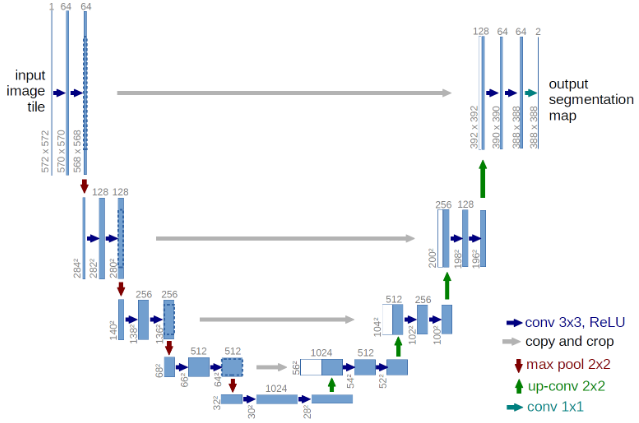

In [0]:
def get_unet3():
    inputs = Input((img_rows, img_cols, 1))
    nf = 32
    d_rate = 0.2
    conv1 = Conv2D(nf, (3, 3), activation = 'relu', padding='same')(inputs)
    conv1 = Conv2D(nf, (3, 3), activation='relu', padding='same')(conv1)
    SpatialDropout2D(d_rate)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(conv2)
    SpatialDropout2D(d_rate)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(conv3)
    SpatialDropout2D(d_rate)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(conv4)
    SpatialDropout2D(d_rate)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(nf * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(nf * 16, (3, 3), activation='relu', padding='same')(conv5)
    SpatialDropout2D(d_rate)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(nf * 8, (3, 3), activation='relu', padding='same')(conv6)
    SpatialDropout2D(d_rate)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    # up7 = conv3
    conv7 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(nf * 4, (3, 3), activation='relu', padding='same')(conv7)
    SpatialDropout2D(d_rate)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    conv8 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(nf * 2, (3, 3), activation='relu', padding='same')(conv8)
    SpatialDropout2D(d_rate)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    conv9 = Conv2D(nf, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(nf, (3, 3), activation='relu', padding='same')(conv9)
    SpatialDropout2D(d_rate)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [0]:
def get_unet4():
    inputs = Input((img_rows, img_cols, 1))
    nf = 16
    d_rate = 0.5
    conv1 = Conv2D(nf, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    conv1 = Conv2D(nf, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nf * 2, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    conv2 = Conv2D(nf * 2, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nf * 8, (3, 3),  padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    conv4 = Conv2D(nf * 8, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)

    up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3),  padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 8, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7 = conv3
    SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3),  padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    SpatialDropout2D(d_rate)
    conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    SpatialDropout2D(d_rate)
    conv8 = tf.keras.activations.relu(conv8)
    conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3),  padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)

    SpatialDropout2D(d_rate)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [0]:
def get_les_spr(gslice_ind2):
  spr = np.load('spr.npy')
  # pre_blanks_ind = np.load('pre_blanks_ind.npy')
  # post_blanks_ind = np.load('post_blanks_ind.npy')
  # non_blanks_ind = np.load('non_blanks_ind.npy')
  # record_names = np.load('record_dat.npy')
  les_spr = np.zeros(spr.shape, dtype='int16')
  for k in range(len(gslice_ind2)):
    ind = gslice_ind2[k]
    ptr = 0
    # print(sum(spr), sum(pre_blanks_ind) + sum(post_blanks_ind) + sum(non_blanks_ind))
    i = 0
    # print('ind : ' + str(ind))
    while(True):
      # print('i : ' + str(i))
      if ptr + spr[i] < ind:
        ptr += spr[i]
        i += 1    
      else:
        les_spr[i] += 1
        break
      # print('Record : ' + record_names[i] + ' Slice : ' + str(ind - ptr))
      # return (record_names[i] , ind - ptr)
  np.save('les_spr.npy', les_spr)
  return les_spr

In [0]:
imgs_train2, masks_train2, gslice_ind2 = load_train2_data()

In [0]:
les_spr = get_les_spr(gslice_ind2)

In [0]:
imgs_train2.shape, masks_train2.shape, gslice_ind2.shape, sum(les_spr)

((833, 256, 256, 1), (833, 256, 256, 1), (833,), 833)

In [0]:
imgs_train2, masks_train2, imgs_val2, masks_val2, gslice_ind_train2, gslice_ind_val2 = split_train_val(imgs_train2, masks_train2, gslice_ind2, 0.8)

666
666 167


In [0]:
# les_spr, record_names

In [0]:
def get_train2_f(imgs_train2, masks_train2):
  nslices = 50
  imgs_train2_f = np.ndarray((nslices*43, img_rows, img_cols, 1), dtype = 'float32')
  masks_train2_f = np.ndarray((nslices*43, img_rows, img_cols, 1), dtype = 'float32')
  k=0
  for i in range(len(les_spr)):
    print('Record : ' + str(i+1))
    for j in range(les_spr[i]):
      print(i*nslices + j, k)
      imgs_train2_f[i*nslices + j] = imgs_train2[k]
      masks_train2_f[i*nslices + j] = masks_train2[k]
      k += 1
    for l in range(les_spr[i] , nslices):
      print(i*nslices + l)
      imgs_train2_f[i*nslices + l ] = np.zeros((1, img_rows, img_cols, 1))
      masks_train2_f[i*nslices + l ] = np.zeros((1,img_rows, img_cols, 1))
  return imgs_train2_f, masks_train2_f

In [0]:
imgs_train2_f, masks_train2_f = get_train2_f(imgs_train2, masks_train2)

In [0]:
rft = 36
split_val = rft * nslices
imgs_val2_f = imgs_train2_f[split_val:]
masks_val2_f = masks_train2_f[split_val:]
# gslice_ind_val_f = gslice_ind2_f[split_val:]
imgs_train2_f = imgs_train2_f[:split_val]
masks_train2_f = masks_train2_f[:split_val]
# gslice_ind_train_f = gslice_ind2_f[:split_val]

In [0]:
imgs_train2_f.shape, imgs_val2_f.shape

((1800, 256, 256, 1), (350, 256, 256, 1))

In [0]:
### Average dice value in the loss function
model = get_unet_eq()
opt = tf.optimizers.Adam(lr=1e-3)
epochs = 1
batch_size = 2
def train2():
  for epoch in range(1, epochs+1):
    for batch_num in range(0, rft, batch_size):
      print(batch_num)
      print(nslices*batch_num, nslices*(batch_num+batch_size))
      img_batch = imgs_train2_f[nslices*batch_num:nslices*(batch_num+batch_size)]
      mask_batch = masks_train2_f[nslices*batch_num:nslices*(batch_num+batch_size)]
      # print(img_batch.shape, mask_batch.shape)
      with tf.GradientTape() as tape:
        varis = model.trainable_variables
        tape.watch(varis)
        logits = model(img_batch)
        dice_score = dice_coef(mask_batch, logits)
        dice_loss = tf.convert_to_tensor(1.0 - dice_score)
      grads = tape.gradient(dice_loss, varis)
      opt.apply_gradients(zip(grads, varis))

    logits = model(imgs_val2_f)
    dice_score_val = dice_coef(masks_val2_f, logits)
    dice_loss_val = tf.convert_to_tensor(1.0 - dice_score_val)
    print("Epoch: {:3.0f} Train Dice Loss: {:.5f} Train Dice Score: {:.5f} Val Dice Loss : {:.5f} Val Dice Score : {:.5f}".format(epoch, dice_loss, dice_score, dice_loss_val, dice_score_val))

In [0]:
train2()

In [0]:
imgs_train2_f.shape, masks_train2_f.shape, imgs_val2_f.shape, masks_val2_f.shape

((1800, 256, 256, 1),
 (1800, 256, 256, 1),
 (350, 256, 256, 1),
 (350, 256, 256, 1))

In [0]:
les_spr[0]

10

In [0]:
imgs_train2_f.shape

(1720, 256, 256, 1)

In [0]:
    # model2 = get_unet2()
    # model_checkpoint2 = ModelCheckpoint('weights2.h5', monitor='val_loss')

In [0]:
def get_aug_data(imgs, masks):
  # print(imgs.shape)
  shift_range = 50
  p2, p98 = np.percentile(imgs, (2, 98)) 
  aug_imgs = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.float32)
  aug_masks = np.ndarray((masks.shape[0], img_rows, img_cols, 1), dtype=np.float32)
  for ind in range(len(imgs)):
    rand = randint(1,5)
    img = imgs[ind]
    mask = masks[ind]
    # print('Rand Value : ' + str(rand))
    # print('Before Trans : ')
    # show_imgs([img, mask])

    if rand == 1: 
      print('01 : Exposure Rescale')
      img = exposure.rescale_intensity(img, in_range=(p2, p98))

    elif rand == 2:
      sh_x = randint(-shift_range,shift_range)
      sh_y = randint(-shift_range,shift_range)
      print('02 : Shift : ' + str(sh_x) + str(' ') + str(sh_y))
      img = aug_shift(img, sh_x, sh_y)
      mask = aug_shift(mask, sh_x, sh_y)
               
    elif rand == 3:
      print('03 : Hist Eq')
      img = exposure.equalize_hist(img)

    elif rand == 4:
      shear = round(random.uniform(-0.4, 0.4), 1)
      print('04 : Shear : Value - ' + str(shear))
      afine_tf = transform.AffineTransform(shear = shear)
      img = transform.warp(img, inverse_map = afine_tf)
      mask = transform.warp(mask, inverse_map = afine_tf, mode = 'reflect')

    elif rand == 5:
      ##Try to zoom smaller images
      zoom_factor = round(np.random.uniform(0.8,1.2),1)
      print('05 : Zoom : Factor ' + str(zoom_factor))
      # print('img')
      img = aug_zoom(img, zoom_factor)
      # print('mask')
      mask = aug_zoom(mask, zoom_factor)
    
    # show_imgs([img, mask])
    # print(img.shape)
    # print(mask.shape)
    aug_imgs[ind] = img.reshape((img_rows, img_cols, 1))
    aug_masks[ind] = mask.reshape((img_rows, img_cols, 1))
    # input()
  return aug_imgs, aug_masks

In [0]:
x = imgs_train2
y = masks_train2
for i in range(3):
  aug_imgs, aug_masks = get_aug_data(np.squeeze(x, axis=-1), np.squeeze(y, axis=-1))
  imgs_train2 = np.concatenate((imgs_train2, aug_imgs), axis = 0)
  masks_train2 = np.concatenate((masks_train2, aug_masks), axis = 0)

In [0]:
# Train model 
model2 = get_unet3()
# model_checkpoint2 = ModelCheckpoint('weights2.h5', monitor='val_loss')
history2 = model2.fit_generator(XYaugmentGenerator(imgs_train2, masks_train2, seed, batch_size, image_datagen), verbose=1, steps_per_epoch=np.ceil(float(len(imgs_train2)) / float(batch_size)),
                validation_data = XYaugmentGenerator(imgs_val2, masks_val2, seed, batch_size, image_datagen), validation_steps = np.ceil(float(len(imgs_train2)) / float(batch_size)), shuffle=True, epochs=50)

In [0]:
# Train model With XYaugmentGenerator
model2 = get_unet3()
# model_checkpoint2 = ModelCheckpoint('weights2.h5', monitor='val_loss')
history2 = model2.fit_generator(XYaugmentGenerator(imgs_train2, masks_train2, seed, batch_size, image_datagen), verbose = 1, steps_per_epoch=np.ceil(float(len(imgs_train2)) / float(batch_size)),
                                validation_data = (imgs_val2, masks_val2), shuffle=True, epochs=100)

In [0]:
# Model without Data Augmentation
model2 = get_unet3()
# model_checkpoint2 = ModelCheckpoint('weights2.h5', monitor='val_loss')
history2=model2.fit(imgs_train2, masks_train2, batch_size=20, epochs=100, verbose=1, shuffle=True,
              validation_data = (imgs_val2, masks_val2))
model2.save('model2.h5')
model2.save_weights('w2.h5')
plot_hist(history2)

In [0]:
# Model without Data Augmentation
model4 = get_unet4()
# model_checkpoint2 = ModelCheckpoint('weights2.h5', monitor='val_loss')
history4=model4.fit(imgs_train2, masks_train2, batch_size=20, epochs=50, verbose=1, shuffle=True,
              validation_data = (imgs_val2, masks_val2))
model4.save('model4.h5')
model4.save_weights('w4.h5')
plot_hist(history4)

In [0]:
def get_unet5():
    inputs = Input((img_rows, img_cols, 1))
    nf = 32
    d_rate = 0.8
    reg_factor = 0.0
    SpatialDropout2D(d_rate)
    conv1 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)
    # conv1 = Conv2D(nf, (3, 3), padding='same')(conv1)
    # conv1 = BatchNormalization()(conv1)
    # conv1 = tf.keras.activations.relu(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    SpatialDropout2D(d_rate)
    conv2 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.activations.relu(conv2)
    # conv2 = Conv2D(nf * 2, (3, 3), padding='same')(conv2)
    # conv2 = BatchNormalization()(conv2)
    # conv2 = tf.keras.activations.relu(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    SpatialDropout2D(d_rate)
    conv3 = Conv2D(nf * 4, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.activations.relu(conv3)
    # conv3 = Conv2D(nf * 4, (3, 3),  padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    # conv3 = tf.keras.activations.relu(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    SpatialDropout2D(d_rate)
    conv4 = Conv2D(nf * 4, (3, 3),  kernel_regularizer=l1(reg_factor), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = tf.keras.activations.relu(conv4)
    # conv4 = Conv2D(nf * 8, (3, 3), padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = tf.keras.activations.relu(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    SpatialDropout2D(d_rate)
    conv5 = Conv2D(nf * 4, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = tf.keras.activations.relu(conv5)
    # conv5 = Conv2D(nf * 16, (3, 3),  padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = tf.keras.activations.relu(conv5)

    up6 = concatenate([Conv2DTranspose(nf * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    SpatialDropout2D(d_rate)
    conv6 = Conv2D(nf * 4, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.activations.relu(conv6)
    # SpatialDropout2D(d_rate)
    # conv6 = Conv2D(nf * 8, (3, 3), padding='same')(conv6)
    # conv6 = BatchNormalization()(conv6)
    # conv6 = tf.keras.activations.relu(conv6)

    up7 = concatenate([Conv2DTranspose(nf * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    # up7 = conv3
    SpatialDropout2D(d_rate)
    conv7 = Conv2D(nf * 4, (3, 3),kernel_regularizer=l1(reg_factor), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.activations.relu(conv7)
    SpatialDropout2D(d_rate)
    # conv7 = Conv2D(nf * 4, (3, 3),  padding='same')(conv7)
    # conv7 = BatchNormalization()(conv7)
    # conv7 = tf.keras.activations.relu(conv7)

    up8 = concatenate([Conv2DTranspose(nf * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    # up8 = conv2
    SpatialDropout2D(d_rate)
    conv8 = Conv2D(nf * 2, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = tf.keras.activations.relu(conv8)
    # SpatialDropout2D(d_rate)
    # conv8 = Conv2D(nf * 2, (3, 3),  padding='same')(conv8)
    # conv8 = BatchNormalization()(conv8)
    # conv8 = tf.keras.activations.relu(conv8)

    up9 = concatenate([Conv2DTranspose(nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    # up9 = conv1
    SpatialDropout2D(d_rate)
    conv9 = Conv2D(nf, (3, 3), kernel_regularizer=l1(reg_factor), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = tf.keras.activations.relu(conv9)
    # SpatialDropout2D(d_rate)
    # conv9 = Conv2D(nf, (3, 3), padding='same')(conv9)
    # conv9 = BatchNormalization()(conv9)
    # conv9 = tf.keras.activations.relu(conv9)

    SpatialDropout2D(d_rate)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss2, metrics=[dice_coef2])
    return model

Train for 36 steps, validate for 7 steps
Epoch 1/100
36/36 [==============================] - 22s 605ms/step - loss: 0.9921 - dice_coef2: 0.0079 - val_loss: 0.9979 - val_dice_coef2: 0.0021
Epoch 2/100
36/36 [==============================] - 18s 511ms/step - loss: 0.9895 - dice_coef2: 0.0105 - val_loss: 0.9978 - val_dice_coef2: 0.0022
Epoch 3/100
36/36 [==============================] - 18s 512ms/step - loss: 0.9867 - dice_coef2: 0.0133 - val_loss: 0.9975 - val_dice_coef2: 0.0025
Epoch 4/100
36/36 [==============================] - 18s 512ms/step - loss: 0.9847 - dice_coef2: 0.0153 - val_loss: 0.9989 - val_dice_coef2: 0.0011
Epoch 5/100
36/36 [==============================] - 18s 511ms/step - loss: 0.9822 - dice_coef2: 0.0178 - val_loss: 0.9986 - val_dice_coef2: 0.0014
Epoch 6/100
36/36 [==============================] - 18s 512ms/step - loss: 0.9796 - dice_coef2: 0.0204 - val_loss: 0.9921 - val_dice_coef2: 0.0079
Epoch 7/100
36/36 [==============================] - 18s 512ms/step - l

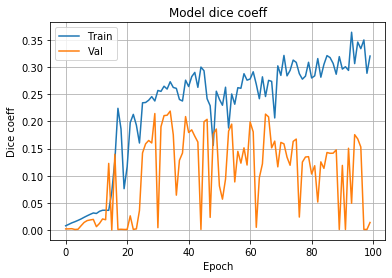

In [0]:
#Using tf.data.Dataset
imgs_train2_f = tf.convert_to_tensor(imgs_train2_f)
masks_train2_f = tf.convert_to_tensor(masks_train2_f)
train_data = tf.data.Dataset.from_tensor_slices((imgs_train2_f, masks_train2_f))
train_data = train_data.batch(nslices).shuffle(nslices).repeat()

imgs_val2_f = tf.convert_to_tensor(imgs_val2_f)
masks_val2_f = tf.convert_to_tensor(masks_val2_f)
val_data = tf.data.Dataset.from_tensor_slices((imgs_val2_f, masks_val2_f))
val_data = val_data.batch(nslices)

model5 = get_unet()
model_checkpoint5 = ModelCheckpoint('weights5.h5', monitor='val_loss')
history5=model5.fit(train_data, steps_per_epoch = rft, epochs=100, verbose=1,
              validation_data = val_data, validation_steps = 43-rft)

model5.save('model5.h5')
model5.save_weights('w5.h5')
plot_hist(history5)

In [0]:
imgs_train2_f.shape, masks_train2_f.shape, imgs_val2_f.shape, masks_val2_f.shape

(TensorShape([1800, 256, 256, 1]),
 TensorShape([1800, 256, 256, 1]),
 (350, 256, 256, 1),
 (350, 256, 256, 1))

In [0]:
# Model without Data Augmentation
model5 = get_unet()
model_checkpoint5 = ModelCheckpoint('weights5.h5', monitor='val_loss')
history5=model5.fit(imgs_train2_f, masks_train2_f, batch_size=nslices, epochs=100, verbose=1, shuffle=False,
              validation_data = (imgs_val2_f, masks_val2_f), class_weight = class_weight)
model5.save('model5.h5')
model5.save_weights('w5.h5')
plot_hist(history5)

Train on 1800 samples, validate on 350 samples
Epoch 1/100
1800/1800 [==============================] - 23s 13ms/sample - loss: 0.9937 - dice_coef2: 0.0063 - val_loss: 0.9980 - val_dice_coef2: 0.0020
Epoch 2/100
1800/1800 [==============================] - 18s 10ms/sample - loss: 0.9906 - dice_coef2: 0.0094 - val_loss: 0.9959 - val_dice_coef2: 0.0041
Epoch 3/100
1800/1800 [==============================] - 18s 10ms/sample - loss: 0.9883 - dice_coef2: 0.0117 - val_loss: 0.9957 - val_dice_coef2: 0.0043
Epoch 4/100
1800/1800 [==============================] - 18s 10ms/sample - loss: 0.9870 - dice_coef2: 0.0130 - val_loss: 0.9968 - val_dice_coef2: 0.0032
Epoch 5/100
1800/1800 [==============================] - 18s 10ms/sample - loss: 0.9844 - dice_coef2: 0.0156 - val_loss: 0.9959 - val_dice_coef2: 0.0041
Epoch 6/100
1800/1800 [==============================] - 18s 10ms/sample - loss: 0.9821 - dice_coef2: 0.0179 - val_loss: 0.9961 - val_dice_coef2: 0.0039
Epoch 7/100
1800/1800 [============

KeyboardInterrupt: ignored

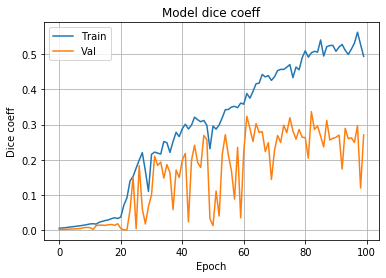

In [0]:
plot_hist(history5)